In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
%load_ext memory_profiler

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re


sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
module = fc.eightb.preselection.ranked_quadh

signal = ObjIter([Tree(fn) for fn in module.signal_list])

100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


In [3]:
bkg = ObjIter([Tree(module.QCD_B_List), Tree(module.TTJets)])
# bkg = ObjIter([])
bkg.reweight(2.3)
bkg.set_systematics([0.2])

100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


[None, None]

# Event Selection
## - Trigger applied | HLT_PFHT330PT30_QuadPFJet_75_60_45_40_TriplePFBTagDeepCSV_4p5
## - Required at least 8 jets to pass preselection
## - Preselections: Jet $P_{T} > 20$ [GeV], Jet $|\eta| < 2.5$, Tight Jet ID
## - MC QCD + TTBar rescaled by $2.3\pm20\%$ to better model data
## - All X->YY->4H scaled to 1 pb, (H->bb)$^4$ branching ratio then applied

# B-Tag Multiplicities
## Investigate cuts on selecting specific B-Tag multiplicity bins
### for example: n_loose_btag == 6, or n_loose_btag == 7

100%|██████████| 3/3 [00:08<00:00,  2.87s/it]


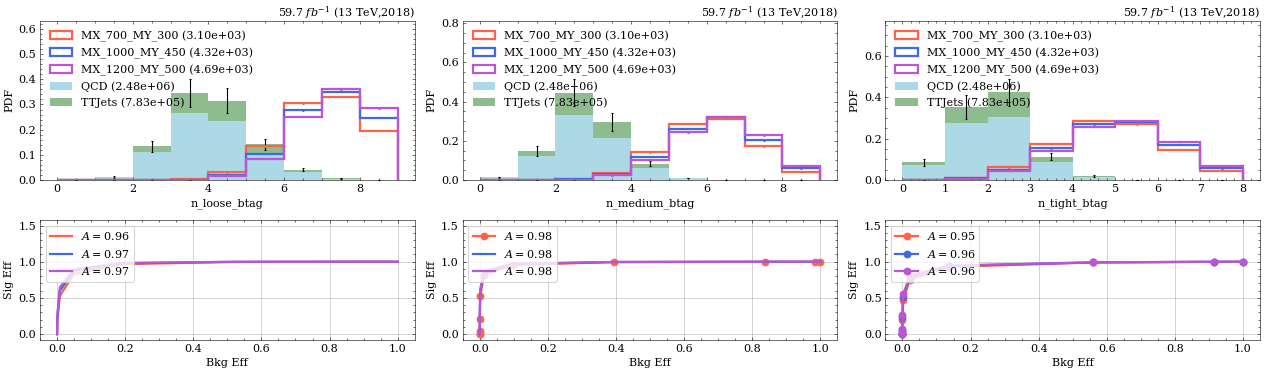

In [4]:
study.quick(
    signal+bkg, legend=True,
    efficiency=True,
    varlist=['n_loose_btag','n_medium_btag','n_tight_btag'],
    dim=-1,
    **study.auroc
)

100%|██████████| 3/3 [00:02<00:00,  1.01it/s]


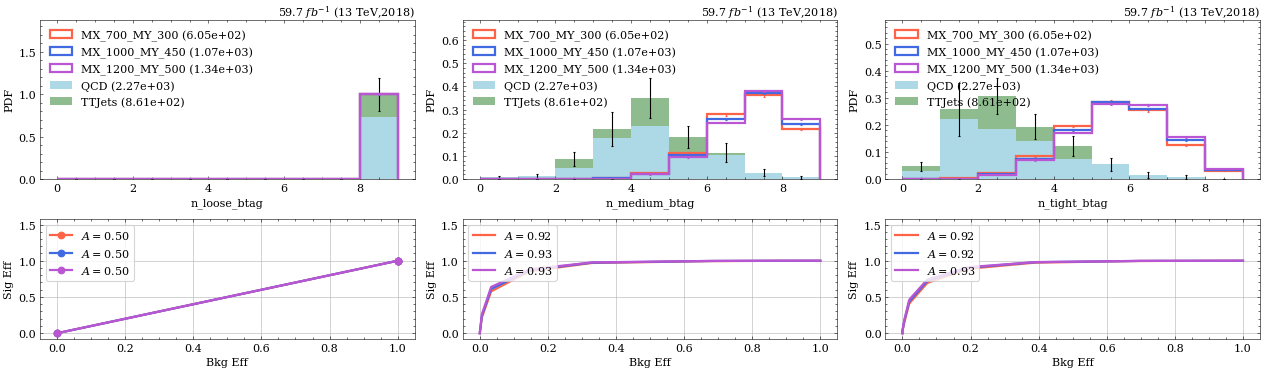

In [71]:
study.quick(
    signal+bkg, 
    masks=lambda t:t.n_loose_btag == 8,
    legend=True,
    efficiency=True,
    varlist=['n_loose_btag','n_medium_btag','n_tight_btag'],
    binlist=[np.arange(10)]*3,
    dim=-1,
    **study.auroc

)

In [17]:
def hm_asym(t):
    hm = ak_stack(ak.unzip(t[[f"{higgs}_m" for higgs in eightb.higgslist]]))
    hm = ak.sort( np.abs(hm), axis=-1, ascending=False )
    hm_avg = ak.mean(hm, axis=-1)
    asym = (hm[:,0] - hm[:,3])/(hm[:,1] + hm[:,2])
    t.extend(hm_asym=asym)

    
(signal+bkg).apply(hm_asym)

[None, None, None, None, None]

In [67]:
def y_jet_btagmulti(t):
    y1_btag = ak_stack(ak.unzip(t[[f"H{i}Y1_b{j}_btag" for i in range(1,3) for j in range(1,3)]]))
    y2_btag = ak_stack(ak.unzip(t[[f"H{i}Y2_b{j}_btag" for i in range(1,3) for j in range(1,3)]]))

    for wp, label in zip(jet_btagWP[1:-1], wplabels[1:]):
        t.extend(**{
            f"n_{label}_btag_y1":ak.sum( y1_btag > wp, axis=-1),
            f"n_{label}_btag_y2":ak.sum( y2_btag > wp, axis=-1),
        })
(signal+bkg).apply(y_jet_btagmulti)

[None, None, None, None, None]

In [68]:
loose_btag_require = EventFilter("n_loose_btag==8",filter=lambda t:t.n_loose_btag==8)
f_signal = signal.apply(loose_btag_require)
f_bkg = bkg.apply(loose_btag_require)

100%|██████████| 4/4 [00:00<00:00,  6.76it/s]


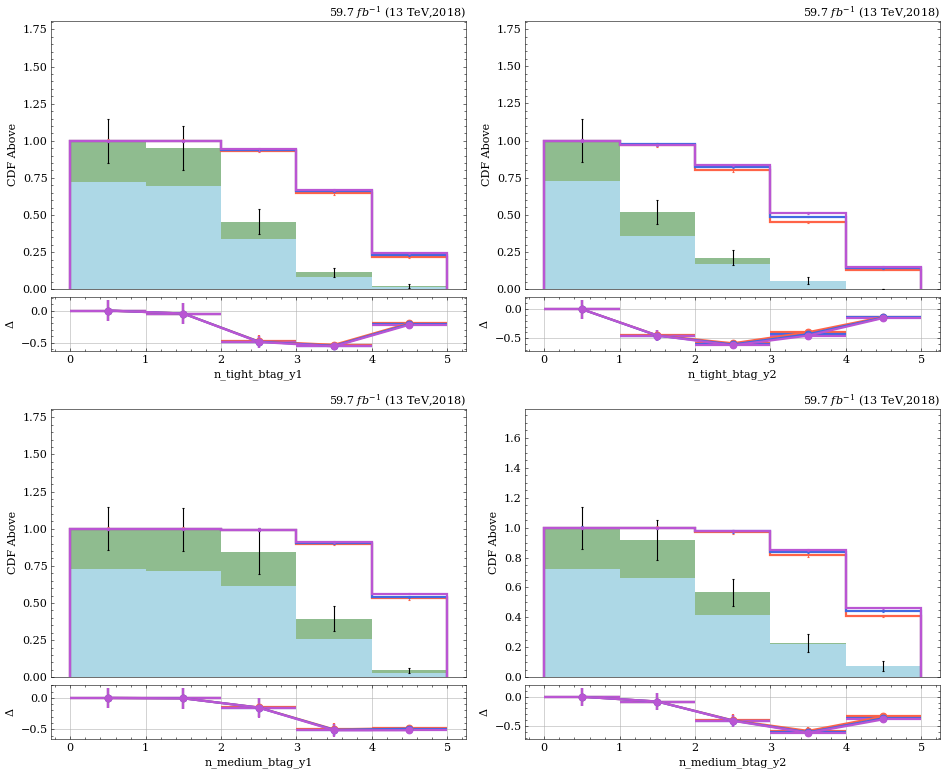

In [69]:
study.quick( 
    f_signal+f_bkg,
    efficiency=True,
    # log=True,
    varlist=[
        'n_tight_btag_y1','n_tight_btag_y2',
        'n_medium_btag_y1','n_medium_btag_y2'
    ],

    binlist=[np.arange(6)]*2,
    # exe=draw_abcd(x_r=(0,2,5),y_r=(0,2,5))
    # **study.auroc,
    cumulative=-1, difference=True,
)

100%|██████████| 2/2 [00:01<00:00,  1.66it/s]


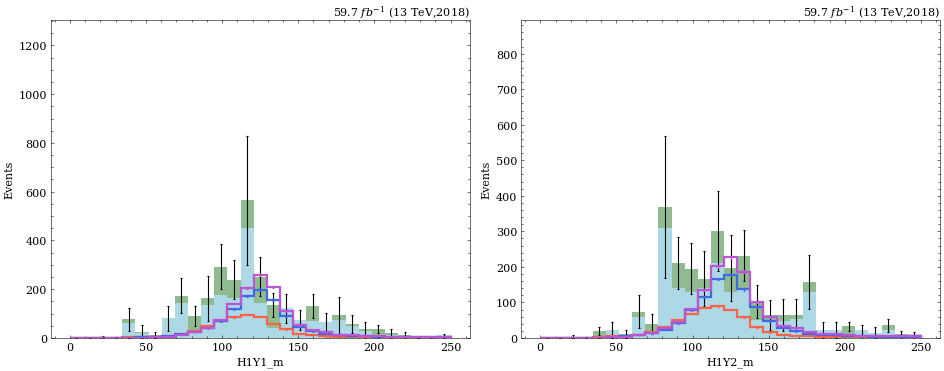

In [73]:
study.quick(
    f_signal+f_bkg,
    varlist=['H1Y1_m','H1Y2_m']
)

In [41]:
bdt = ABCD(
    features=['X_pt','Y1_pt','Y2_pt'],
    a = lambda t : (t.n_tight_btag_y1 >= 2) & (t.n_medium_btag_y2 >= 2),
    b = lambda t : (t.n_tight_btag_y1 >= 2) & (t.n_medium_btag_y2 <  2),
    c = lambda t : (t.n_tight_btag_y1 <  2) & (t.n_medium_btag_y2 >= 2),
    d = lambda t : (t.n_tight_btag_y1 <  2) & (t.n_medium_btag_y2 <  2),
)

100%|██████████| 1/1 [00:16<00:00, 16.15s/it]


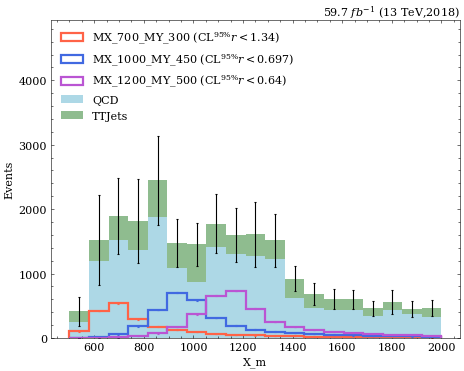

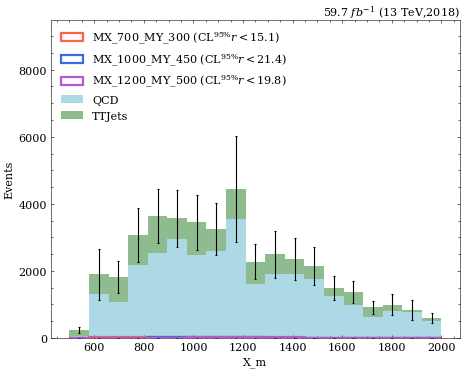

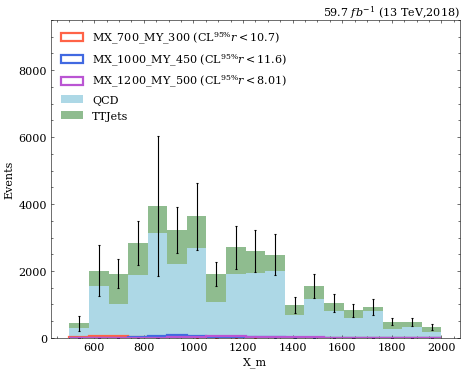

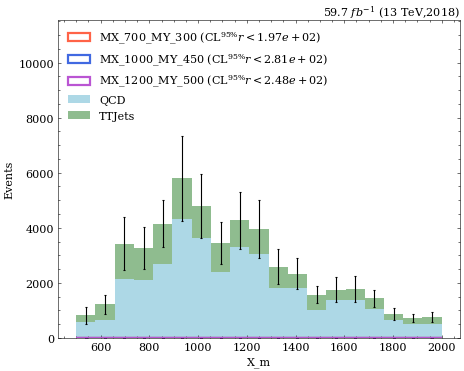

In [45]:
for r in ("a","b","c","d"):
    study.quick( 
        f_signal+f_bkg, 
        legend=True,
        masks=getattr(bdt, r),
        varlist=["X_m"],
        binlist=[(500,2000,20)],
        limits=True,
    )